# Dog Detection CNN Model

Attempt to get my friend's attention by making them use this on their dog. Practicing with TensorFlow is nice too, I guess.

\#BornToUseCamelCase_forced_to_use_snake_case

### Load dependencies

In [70]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from typing import Union

### Task 1: Prepare the dataset

We will be using the Stanford dogs Image Dataset from Roboflow. It contains 23 223 jpg images of dogs, labelled with bounding boxes. It's too large to commit, so you'll have to download it manually, and add it to this directory. Download it from the site below. Make sure to select the Tensorflow Object Detection CSV format.

https://universe.roboflow.com/igor-romanica-gmail-com/stanford-dogs-0pff9

Once that's done, we can parse the data into a tf.keras.utils.Sequence object that will serve as our dataset.

In [71]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Data Generator class. Inherits from tf.keras.utils.Sequence

    >>> batch_size = 32
    >>> image_size = (224, 224)
    >>> csv_file = 'path/to/your/annotations.csv'
    >>> image_dir = 'path/to/your/images'
    >>> data_generator = CustomDataGenerator(csv_file, image_dir, batch_size, image_size)
    """
    # Attr types
    data: pd.DataFrame
    image_dir: str
    batch_size: str
    image_size: tuple[int, int]
    num_samples: int
    normalized: bool

    def __init__(
        self,
        csv_file: str,
        image_dir: str,
        batch_size: int,
        image_size: tuple[int, int, int],
        ) -> None:
        """
        DataGenerator constructor method.
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = len(self.data)
        self.normalized = False

        # hardcoded label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.data["class"])

    def __len__(self) -> int:
        """
        Return number of images per mini-batch.
        """
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index) -> tuple[np.ndarray, np.ndarray]:
        """
        Get the i-th batch as a numpy array of images, followed by a numpy array of annotations.
        """
        batch_data = self.data.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        annotations = []

        for _, row in batch_data.iterrows():
            # process image path
            image_path = row['filename']
            
            # read image
            image = cv2.imread(os.path.join(self.image_dir, image_path))
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))

            # extract bounding box
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_label = row['class']

            # encode class label
            class_label_encoded = self.label_encoder.transform([class_label])[0]

            # convert from uint8 to float32
            image = image.astype('float32')

            # store image and annotation
            images.append(image)
            annotations.append((xmin, ymin, xmax, ymax, class_label_encoded))

        return np.array(images), np.array(annotations)
    
    def get_classes(self) -> set[str]:
        """
        Return a set of the unique labels in the dataset.
        """
        return set(self.data["class"])
    
    def normalize(self, mean: np.ndarray, std: np.ndarray) -> None:
        """
        # FIXME: don't need this

        Normalize the images in the dataset according to mean and std,
        then store the resultant images in the normalized_image column
        of data.

        Do nothing if the images are already normalized.
        """
        if not self.normalized:
            for i in range(self.num_samples):
                # get the image
                path = self.data.iloc[i]["filename"]
                image = cv2.imread(os.path.join(self.image_dir, path))
                image = cv2.resize(image, self.image_size)
                
                # normalize
                image = (image - mean) / std
                
                # override
                self.data.at[i, "normalized_image"] = image

In [72]:
# Create training set
# we will create the validation and test sets afterwards, to save memory for tasks like normalization
X_train = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/train/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/train",
    32,
    (224, 224, 3)
)
X_test = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/test/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/test",
    32,
    (224, 224, 3)
)
X_valid = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/valid/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/valid",
    32,
    (224, 224, 3)
)

In [73]:
# Check that data loaded properly
X_train.data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,n02101388_1941_jpg.rf.3c607af1ab5a273782f4571c...,416,416,Brittany_spaniel,0,0,416,393
1,n02110627_8949_jpg.rf.3c46c1369619b5bb5cfdb3a1...,416,416,affenpinscher,56,5,357,416
2,n02104365_8466_jpg.rf.3c5461b0f06c5f16c429325a...,416,416,schipperke,82,28,310,416
3,n02110627_8048_jpg.rf.3c48c2201000f8ff85d61771...,416,416,affenpinscher,0,0,394,413
4,n02100877_239_jpg.rf.3c5813c61b445e08fff6c09b4...,416,416,Irish_setter,28,5,411,416


In [74]:
# number of images in our training set
len(X_train.data)

21694

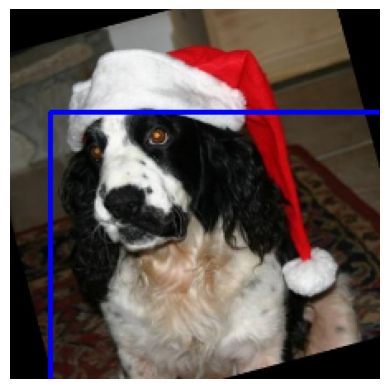

Class: English_springer


In [75]:
def display(sample: tuple[np.ndarray, np.ndarray], index: int) -> None:
    """
    Display the image at <index> in the given batch of images <sample> from a DataGenerator.
    """
    # get the image and it's annotations
    batch, annotations = sample
    sample_image, sample_annotation = batch[index], annotations[index]
    # convert from BGR (opencv default for some reason) to RGB (matplotlib default)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    # images were initially uint8, but we changed it to float32 to be accepted by the model
    # revert it to dtype uint8
    sample_image = sample_image.astype("uint8")
    # draw the bounding box
    xmin, ymin, xmax, ymax, label = sample_annotation
    cv2.rectangle(
        sample_image,
        (xmin, ymin),
        (xmax, ymax),
        (0, 0, 255), # blue
        2
    )
    # shoe the image and caption
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()
    # decode label
    label = X_train.label_encoder.inverse_transform([label])[0]
    print(f"Class: {label}")

# Select the first batch
sample_batch = X_train[0]

# change this to any $i \in \mathbb{N}$ such that 
# 0 <= i <= batch_size - 1 (i'd write this in LaTeX too 
# but it gets too confusing for my intended audience)
i = 5

display(sample_batch, i)

Awesome, our data loaded properly!

### Task 2: Preprocess the dataset

...

### Task 3: Build the algorithm

We are going to implement the YOLO algorithm with \{features\} using Keras' Functional API.

In [76]:
def yolo_filter_boxes(
                      boxes: tf.Tensor,
                      box_confidence: tf.Tensor,
                      box_class_probs: tf.Tensor,
                      threshold: float = 0.6
                      ) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    Given bounding box estimates, filter them according to <threshold> and return results.
    """
    # get box scores with element-wise tensor multiplication
    box_scores = box_confidence * box_class_probs
    # select the classes with the highest scores (argmax)
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    # create a filtering mask of booleans using threshold
    filter_mask = box_class_scores >= threshold
    # apply the mask
    scores = tf.boolean_mask(box_class_scores, filter_mask)
    boxes = tf.boolean_mask(boxes, filter_mask)
    classes = tf.boolean_mask(box_classes, filter_mask)

    return scores, boxes, classes

In [77]:
def iou(
        box1: tuple[float, float, float, float],
        box2: tuple[float, float, float, float]) -> float:
    """
    Return the intersection-over-union (IoU) of box1 and box2.
    """
    # unpack the coords of the bounding boxes
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # calculate the intersecting area
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,xi2 - xi1)
    inter_height =  max(0,yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # compute union with the principle of inclusion-exclusion: Union(A,B) = A + B - Inter(A,B)
    # PIE as my discrete math prof abbreviates it
    box1_area = (box1_y2 - box1_y1) * (box1_x2 - box1_x1)
    box2_area = (box2_y2 - box2_y1) * (box2_x2 - box2_x1)
    union_area = box2_area + box1_area - inter_area
    
    # compute the IoU and return
    return inter_area / union_area

In [78]:
def yolo_non_max_suppression(
        scores: tf.Tensor,
        boxes: tf.Tensor,
        classes: tf.Tensor,
        max_boxes: int = 10,
        iou_threshold: float = 0.5
        ) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    # TODO: update docstring from deep learning spec
    Apply Non-max suppression (NMS) to set of boxes. This task removes boxes that target the same
    objects in the image by comparing their iou to the iou_threshold. For convenience, we utilize 
    tf.image.non_max_suppression, which returns the indices of boxes to keep after non max suppression.
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    # tensor to be used in tf.image.non_max_suppression()
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')

    # use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    
    # use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

Here are some functions that will format the output of the deep CNN.

In [79]:
def yolo_boxes_to_corners(box_xy, box_wh) -> tf.Tensor:
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

def scale_boxes(boxes: tf.Tensor, image_shape: tuple[int, int]) -> tf.Tensor:
    """Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = keras.backend.stack([height, width, height, width])
    image_dims = keras.backend.reshape(image_dims, (1, 4))  # same shape from deep learning spec?
    boxes = boxes * image_dims
    return boxes

def yolo_eval(
    yolo_outputs: tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor],
    image_shape: tuple[tf.float32, tf.float32] = (224, 224),
    max_boxes: int = 10,
    score_threshold: float = .6,
    iou_threshold: float = .5) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    Converts the output of YOLO encoding (a lot of boxes) to your 
    predicted boxes along with their scores, box coords, and classes.

    returns scores, boxes, classes as tf.Tensors
    """
    
    # retrieve yolo model outputs
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # convert boxes to corner coordinates using our helper
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # filer the boxes with the score_threshold
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # apply non max suppression to the resultant boxes
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

We now have all the methods we need to perpetrate the YOLO algorithm.

### Creating the model

We define the model as a subclass of the tf.keras.Model class from keras' functional API. We will override the constructor, as well as the call, compute_loss, and train_step methods to incorporate our YOLO functionality.

Note that we aren't using tf.keras.Sequential because overriding it's high-level implementation would make it no longer robust.

In [86]:
class DogDetect(tf.keras.Model):
    """
    Dog Detection CNN model which utilizes the YOLO algorithm.

    Inherits from tf.keras.Model
    
    TODO: finish the docstring
    >>> model = DogDetect()
    >>> ...
    """
    # Attr types
    num_classes: int
    num_anchors: int
    yolo_layers: list[keras.layers.Layer]
    conv_box_xy: keras.layers.Conv2D    
    conv_box_wh: keras.layers.Conv2D
    conv_confidence: keras.layers.Conv2D
    conv_class_probs: keras.layers.Conv2D

    def __init__(self, num_classes: int, num_anchors: int) -> None:
        """
        Construct a DogDetect model.
        """
        super(DogDetect, self).__init__()
        self.num_classes = num_classes  # labels
        self.num_anchors = num_anchors  # bounding boxes

        # hidden layers
        self.yolo_layers = [
            # Convolutional block 1
            Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=(2, 2)),

            # Convolutional block 2
            Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=(2, 2)),

            # Convolutional block 3
            Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=(2, 2)),

            # Convolutional block 4
            Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=(2, 2)),

            # Convolutional block 5
            Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=(2, 2)),
     ]

        # output layers
        self.conv_box_xy = Conv2D(filters=num_anchors*2, kernel_size=1, strides=1, padding='same', name='conv_box_xy')
        self.conv_box_wh = Conv2D(filters=num_anchors*2, kernel_size=1, strides=1, padding='same', name='conv_box_wh')
        self.conv_confidence = Conv2D(filters=num_anchors*num_classes, kernel_size=1, strides=1, padding='same', name='conv_confidence')
        self.conv_class_probs = Conv2D(filters=num_anchors*num_classes, kernel_size=1, strides=1, padding='same', name='conv_class_probs')


    def call(self, inputs: np.ndarray, training: bool = False, mask = None) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        1 iteration of forward propagation.
        """
        # TODO: implement masking functionality
        if mask:
            raise NotImplementedError
            #return tf.Tensor(), tf.Tensor(), tf.Tensor()
        if training:
            # This is for when we are training the model on an image
            # Called in train_step

            # variable for forward propagation
            x = inputs
            
            # pass through hidden layers
            for layer in self.yolo_layers:
                x: tf.Tensor = layer(x)

            box_xy = self.conv_box_xy(x)
            box_wh = self.conv_box_wh(x)
            confidence = self.conv_confidence(x)
            #class_probs = self.conv_class_probs(x)

            return box_xy, box_wh, confidence
        else:
            # This is for inference/evaluation
            # Makes a prediction on one image,
            # Does not affect weights

            # variable for forward propagation
            x = inputs
            
            # pass through hidden layers
            for layer in self.yolo_layers:
                x: tf.Tensor = layer(x)

            box_xy = self.conv_box_xy(x)
            box_wh = self.conv_box_wh(x)
            confidence = self.conv_confidence(x)
            class_probs = self.conv_class_probs(x)

            # apply YOLO algorithm
            scores, boxes, classes = yolo_eval((box_xy, box_wh, confidence, class_probs))
            return scores, boxes, classes


    def compute_loss(
        self,
        y_true: tf.Tensor,
        y_pred: tuple[tf.Tensor, tf.Tensor, tf.Tensor]
        ) -> float:
        """
        Loss function L

        Computes mean squared error for bounding boxes,
        binary crossentropy for confidence,
        categorical crossentropy for class.

        Return the loss between y_true and y_pred
        """
        # we start by extracting scores, boxes, and classes from y_true and y_pred

        # y_true
        # convert annotations numpy array to tensors
        true_classes = y_true[:, :, 0]
        true_boxes = y_true[:, :, 1:]

        # initialize scores as 1 for each box
        true_scores = tf.ones_like(true_classes, dtype=tf.float32)

        # y_pred
        pred_scores, pred_boxes, pred_classes = y_pred

        # extract localization components
        pred_box_xy, pred_box_wh = pred_boxes[..., :2], pred_boxes[..., 2:]
        true_box_xy, true_box_wh = true_boxes[..., :2], true_boxes[..., 2:]

        # localization loss (mean squared error)
        loc_loss = tf.reduce_sum(tf.square(pred_box_xy - true_box_xy) + tf.square(tf.sqrt(pred_box_wh) - tf.sqrt(true_box_wh)))

        # confidence loss (binary crossentropy)
        conf_loss = tf.reduce_sum(tf.square(pred_scores - true_scores))

        # classification loss (categorical crossentropy)
        class_loss = tf.reduce_sum(tf.square(pred_classes - true_classes))

        # result
        total_loss = loc_loss + conf_loss + class_loss
        return total_loss

    def train_step(self, data: tuple[tf.Tensor, tf.Tensor]) -> dict[str, float]:
        """"
        1 iteration of backpropagation.
        """
        images, targets = data
        with tf.GradientTape() as tape:
            predictions = self.call(images, training=True)
            loss = self.compute_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}

These are all the methods we needed to override. It's time to train the model!

### Train the Model

We will compile our model with the adam optimizer, and our compute_loss method as the loss metric.

In [87]:
# model compilation
num_classes = len(X_train.get_classes())

model = DogDetect(num_classes=num_classes, num_anchors=3)
model.compile(optimizer="adam", loss=model.compute_loss)

In [88]:
# hyperparameters
NUM_EPOCHS = 2

# train the model
history = model.fit(
    X_train,
    epochs=NUM_EPOCHS,
    validation_data=X_valid
)

Epoch 1/2


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/dy/4wm1kh956cg7ftgc7v9bwj2w0000gn/T/ipykernel_61283/1768145160.py", line 166, in train_step
        loss = self.compute_loss(targets, predictions)
    File "/var/folders/dy/4wm1kh956cg7ftgc7v9bwj2w0000gn/T/ipykernel_61283/1768145160.py", line 133, in compute_loss
        true_classes = y_true[:, :, 0]

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT64, begin_mask=3, ellipsis_mask=0, end_mask=3, new_axis_mask=0, shrink_axis_mask=4](IteratorGetNext:1, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [?,?], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


### Validate the model

We use ___ to measure the accuracy of the model so far.

In [ ]:
...

### Save model to working directory

Now let's store the model. Choose a name for the .h5 file below. 

We can load this model using keras.models.load_model to access this when we wish to use it inferentially.

In [ ]:
# name your model
name = "paw_patrol_beta"

# make sure it's not taken
assert not os.path.exists(os.getcwd() + f"saved_models/{name}")

# save it to desired name
model.save(f"saved_models/{name}")